# MA755 - Team Sandbox

Material from _Chapter 3. Classification_ of

>"[Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do)"<br>
by Aurélien Géron
Published by O'Reilly Media, Inc., 2017

Annotations, comments, and implementation on dataset by Angela Su, Tyler Miguel, Sebastian Bury

# Introduction

This is a College Scorecard dataset that gives various information about university and student level factors, such as college addmission, cost and finanaical aid, and student body demographics. This data is designed to "increase transparency" of "college costs and outcomes" to help students and families make informed decisions about the cost of furthering education. The data provided is aggregated at the institutional levels.

In this notebook, we will be working with this data to perform a supervised learning technique to classify institutions based on the mean income a student at that institution earns, 10 years after graduating. We will look to classify each institution into one of three groups: low, medium, and high earnings. But first, we will load in the require packages that will use throughout the analysis.

# Load Packages

In [155]:
# add packages that we use
# and then come back to this to remove this tetxt

import os
import zipfile
from six.moves import urllib

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import precision_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score


In [ ]:
# not yet used (don't run)

from sklearn.datasets.mldata import fetch_mldata
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model    import SGDClassifier
from sklearn.preprocessing   import LabelBinarizer
from sklearn.preprocessing   import StandardScaler
from sklearn.multiclass      import OneVsRestClassifier
from sklearn.multiclass      import OneVsOneClassifier
from scipy.stats             import describe
from sklearn.calibration     import CalibratedClassifierCV

# Import Data

We start by downloading the dataset from online. To do this, we created a function to download the data from the US Department of Education website and extract the files from the zip file.

In [3]:
DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/"
COLLEGE_PATH = "downloads"
COLLEGE_URL = DOWNLOAD_ROOT + COLLEGE_PATH + "/CollegeScorecard_Raw_Data.zip"
TO_PATH = "datasets/college"

def fetch_college_data(college_url=COLLEGE_URL, to_path=TO_PATH):
    os.makedirs(to_path, exist_ok=True)
    zip_path = os.path.join(to_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path)
    college_zip.extractall(path=to_path)
    college_zip.close()

In [ ]:
fetch_college_data() # only run if you don't already have the data local

The file `CollegeScorecard_Raw_Data.zip` is downloaded into the `datasets/college` directory. The unzipped `CollegeScorecard_Raw_Data` is created in the same directory. The file `MERGED2012_13_PP.csv`, which contains the most recent earnings data from College Scorecard data is stored in the `CollegeScorecard_Raw_Data` directory. 

We will load `MERGED2012_13_PP.csv` into our notebook. Additionally, we will load `MERGED2014_15_PP.csv` into our notebook so that we can extract key descriptive information about the universities that is not present in the `MERGED2012_13_PP.csv` file. 

In addition to loading the CSV into our notebook, we will do some data cleaning within our `load_college_data()` function to ensure the data structure of the features in the CSV file. Specifically, we noticed the file contained the string value "PrivacySuppressed" in many numeric fields. We converted these to `NaN` values. Furthermore, some of the string values in our dataframe were not rendering correct, so we explicitly stated the `dtype` of three columns, `ZIP`, `NPCURL`, and `ALIAS`.


In [4]:
def load_college_data(file, data_path=TO_PATH):
    csv_path = os.path.join(data_path, "CollegeScoreCard_Raw_Data",
                            file)
    return pd.read_csv(csv_path, na_values = "PrivacySuppressed", 
                       dtype = {'ZIP':str,
                                'NPCURL':str,
                                'ALIAS':str})

Load the data from the `MERGED2012_13_PP.csv` and `MERGED2014_15_PP.csv` file into a `DataFrame` Pandas object stored in `college`. 

In [5]:
college_1213 = load_college_data(file='MERGED2012_13_PP.csv')
college_1415 = load_college_data(file='MERGED2014_15_PP.csv')
print(type(college_1213))
college_1213.head()

<class 'pandas.core.frame.DataFrame'>


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1133.0,NaN,NaN,1,0.4879,0.5121,1405.0,1574.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.290236,1485.0,NaN,NaN,1,0.4200,0.5800,3153.0,3481.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,1.0,NaN,NaN,1,0.4379,0.5621,264.0,336.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.307116,801.0,NaN,NaN,1,0.5425,0.4575,1208.0,1392.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1298.0,NaN,NaN,1,0.4046,0.5954,1951.0,1961.0


Each row is an institution with 1743 attributes as columns.

In [6]:
college_1213.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793 entries, 0 to 7792
Columns: 1743 entries, ﻿UNITID to CDR2_DENOM
dtypes: float64(1724), int64(11), object(8)
memory usage: 103.6+ MB


This `.info()` method returns a brief description of the dataset, with each attribute from the columns and the type of the object. For example, we can see that the data in our college dataframe has 1724 float attributes, 11 integer attributes, and 8 object attributes (in our case, string or factor attributes).

# Variable Selection

Given the size of our dataset, we utilized the [College Data Documentation Report](http://https://collegescorecard.ed.gov/data/documentation/) to select our variables of interest. From this document, we were able to select variables of interest to answer our classification question: can we correctly classify each institution into one of three groups that describe the earning potentional of students 10 years after gradaution?


The variables we selected are:

University Description:
- INSTNM (institution name)
- CITY (the city of the school)
- STABBR (state postcode)
- ZIP (zip code)
- LATITUDE (latitude of location)
- LONGITUDE (longitude of location)

Features:
Factor variables
- ADM_RATE (admission rate as a percent)
- MAIN (flag for main campus)
- ICLEVEL (highest level of award: 4-year, 2-year, less than 2-year)
- Control (Public, Private Non-profit, or Private For-Profit)
- HBCU (Historically black college)
- PBI (Predominantly black college)
- ANNHI (Alaska Native-/Native Hawaiian-serving Institutions)
- TRIBAL (Tribal Colleges and Universities)
- AANAPII (Asian American-/Native American-Pacific Islander-serving Institutions)
- HSI (Hispanic-serving Institutions)
- NANTI (Native American Non-Tribal-serving institution)

Label data: 
- MN_EARN_WNE_P10 (Mean Earnings 10 years after college)

The university description variables were chosen to give a basic idea of the universty name and location, both the geographic latitude and longitude as well as city and zip in the state. The factor variables such as admission rate, level of award, and public/private can be correlated to see how these influence median income later for a student on in life. These basic factors were chosen since they give a profile of the school and could relate to later success, as do labels like "historically black college" and other racial indiciators. 

Due to the avaialable data in the `MERGED2012_13_PP.csv`, we had to load the `MERGED2014_15_PP.csv` file to extract longitude, latitude, HBCU, PBI, ANNHI, TRIBAL, AANAPII, HSI, and the NANT variables.

Below, we used both files to extract data and combine to what we will use moving forward. We will extract description data and the data we will use to explore relationships.

In [8]:
inst_1213 = college_1213.loc[:,['INSTNM','CITY','STABBR',
                                     'ZIP','ADM_RATE', 
                                     'MAIN','ICLEVEL',
                                     'CONTROL','MN_EARN_WNE_P10']]

inst_1415 = college_1415.loc[:, ['INSTNM', 'HBCU','PBI',
                                 'ANNHI', 'TRIBAL','AANAPII',
                                 'HSI', 'NANTI', 'LATITUDE','LONGITUDE']]

college = pd.merge(inst_1213, inst_1415, on=['INSTNM'])

Now that we have the variables we want, we will look take a look at our data set and check for missing values

# Remove missing data

First we will examine out dataset to see the spread of missing data.

In [22]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7789 entries, 0 to 7788
Data columns (total 18 columns):
INSTNM             7789 non-null object
CITY               7789 non-null object
STABBR             7789 non-null object
ZIP                7789 non-null object
ADM_RATE           2359 non-null float64
MAIN               7789 non-null int64
ICLEVEL            7789 non-null int64
CONTROL            7789 non-null int64
MN_EARN_WNE_P10    6064 non-null float64
HBCU               7320 non-null float64
PBI                7320 non-null float64
ANNHI              7320 non-null float64
TRIBAL             7320 non-null float64
AANAPII            7320 non-null float64
HSI                7320 non-null float64
NANTI              7320 non-null float64
LATITUDE           7320 non-null float64
LONGITUDE          7320 non-null float64
dtypes: float64(11), int64(3), object(4)
memory usage: 1.1+ MB


It appears that `ADM_RATE` has a large amount of missing values. There are three options to account for missing values, we can:

Option 1: removes the corresponding institutions  
Option 2: removes the entire attribute  
Option 3: sets the values to something else (0, mean or median, etc.)

Given that over 60% of the admission rate data is empty, we will remove the institutions that don't have this data available. If we chose to fill in the attribute with a value, such as the median, we believe that we would significantly alter our classifications. 

The goal of this analysis is to accurately classify the institutions based on `MN_EARN_WNE_P10`, so we want to esnure we have a full working sample of data before moving on.

To so this, we will removed the data that is missing and store it in a new pandas data frame. Then we will reset the index of the rows.

In [26]:
college = college.dropna(subset=['ADM_RATE', 
                                 'MN_EARN_WNE_P10',
                                 'HBCU'])

college = college.reset_index(drop=True)

In [27]:
type(college)

pandas.core.frame.DataFrame

# Examine new sample

Let's take a look at our data just to make sure we have a fully populated data set.

In [31]:
college.isnull().sum()

INSTNM             0
CITY               0
STABBR             0
ZIP                0
ADM_RATE           0
MAIN               0
ICLEVEL            0
CONTROL            0
MN_EARN_WNE_P10    0
HBCU               0
PBI                0
ANNHI              0
TRIBAL             0
AANAPII            0
HSI                0
NANTI              0
LATITUDE           0
LONGITUDE          0
dtype: int64

We now have a full dataset with no missing values. Now we will take a look at our data.

In [32]:
college.describe()

,ADM_RATE,MAIN,ICLEVEL,CONTROL,MN_EARN_WNE_P10,HBCU,PBI,ANNHI,TRIBAL,AANAPII,HSI,NANTI,LATITUDE,LONGITUDE
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.0,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,0.665967,0.823364,1.160748,1.941121,44498.130841,0.030841,0.011215,0.002804,0.0,0.024766,0.058411,0.004673,38.102104,-88.534309
std,0.199366,0.381449,0.441375,0.698151,12870.504612,0.172928,0.105330,0.052888,0.0,0.155449,0.234574,0.068215,5.442022,15.287963
min,0.000000,0.000000,1.000000,1.000000,13100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,17.980000,-158.061825
25%,0.539600,1.000000,1.000000,1.000000,36975.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,34.800777,-94.685502
50%,0.685450,1.000000,1.000000,2.000000,42800.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,39.559003,-84.521338
75%,0.812275,1.000000,1.000000,2.000000,50100.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,41.746355,-77.195941
max,1.000000,1.000000,3.000000,3.000000,136400.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,61.191235,-64.972866


# Prepare target attribute

As we can see from our data above, we our `MN_EARN_WNE_P10` variable is numeric and ranges from \$13,100 to \$136,400. To prepare our data for classification, we will first work to transform this attribute to a binary attribute to indicate whether an instituion has the qualities for a "high earning potentional" or "low earning potential". 

We will do this by using the median as a threshold and classifying each instiution above the median as 1 and each institution below the median as 0.

Below, we will intialize the list, `college_earn`, and then run a `for` loop over the `college['MN_EARN_WNE_P10']` attribute that assigns a value of a 1 or 0 based on whether the value of `college['MN_EARN_WNE_P10']` is larger or smaller than the median earnings 10 years after graduation.

In [43]:
college_earn = []

for i in college['MN_EARN_WNE_P10']:
    if i > college['MN_EARN_WNE_P10'].median():
        college.earn = college_earn.append(1)
    else:
        college.earn = college_earn.append(0)

Now we will add this list to the `college` data frame and take a look at the results.

In [46]:
college['earning_potentional'] = college_earn

In [49]:
college.head()

,INSTNM,CITY,STABBR,ZIP,ADM_RATE,MAIN,ICLEVEL,CONTROL,MN_EARN_WNE_P10,HBCU,PBI,ANNHI,TRIBAL,AANAPII,HSI,NANTI,LATITUDE,LONGITUDE,earning_potentional
0,Alabama A & M University,Normal,AL,35762,0.5438,1,1,1,35000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.783368,-86.568502,0
1,University of Alabama at Birmingham,Birmingham,AL,35294-0110,0.7223,1,1,1,46300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.502230,-86.809170,1
2,University of Alabama in Huntsville,Huntsville,AL,35899,0.7766,1,1,1,50400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.722818,-86.638420,1
3,Alabama State University,Montgomery,AL,36104-0271,0.4604,1,1,1,29400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,32.364317,-86.295677,0
4,The University of Alabama,Tuscaloosa,AL,35487-0166,0.5308,1,1,1,48600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.214400,-87.545766,1


We can see from the results above that Alabama A & M University is classified as a 0 for `earning_potential` which is consistent with there `MN_EARN_WNE_P10` being lower than than the median earnings of all instituions.

# Split data

Now that we have prepared our target data, we will split the dataset into a training set and a test set. One reason to do this is so that we can test our model and assess accuracy without being subject to overfitting the model. 

First we will split our training features from our a label data. We will keep our institution names with our training features for now, but we will remove them after we split the training and test data.

In [62]:
college_x = college.drop(['MN_EARN_WNE_P10', 
                          'earning_potentional'], 
                          axis=1)
college_y = college['earning_potentional']

We will now split our training and test data.

In [63]:
train_set, test_set, train_target, test_target = train_test_split(college_x, 
                                                                  college_y, 
                                                                  test_size=0.2, 
                                                                  random_state=75)

In [69]:
train_set.head()

,INSTNM,CITY,STABBR,ZIP,ADM_RATE,MAIN,ICLEVEL,CONTROL,HBCU,PBI,ANNHI,TRIBAL,AANAPII,HSI,NANTI,LATITUDE,LONGITUDE
873,Southeast Missouri State University,Cape Girardeau,MO,63701,0.9724,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.315750,-89.529119
589,Union College,Schenectady,NY,12308-2311,0.3822,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.869066,-83.887982
566,Galen College of Nursing-Louisville,Louisville,KY,40207,0.7270,1,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.277320,-85.697564
1390,University of the Sciences,Philadelphia,PA,19104-4495,0.6334,1,1,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39.946552,-75.208241
1763,Inter American University of Puerto Rico-Fajardo,Fajardo,PR,00738-7003,0.6804,0,1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.329194,-65.648485


Now we can remove the institutions descriptions from our data in our training set and test set.

In [74]:
train_set_inst, train_set = train_set.iloc[:,:4], train_set.iloc[:,4:]
test_set_inst, test_set = test_set.iloc[:,:4], test_set.iloc[:,4:]

Now are data is prepared for our first classification.

# Logistic Regression Classifier

The goal of creating our predictive model is to accurately classify each institution into a high earning institution and a low earning institution.

A logistic regression classifier is a binary classifier that will take our institutions and classify them as either high earning or low earning institutions. The logistic regression classifier does this by minimzing the cost for the prediction.

First we will intialize the logistic regression classifier in `log_clf`.

In [80]:
log_clf = LogisticRegression(solver='liblinear',
                             random_state=42)

Now we can create the model and determine the vector of values that we will use to determine the class of the institution. We will fit the model to find the values of the vector which will minimize our cost.

In [81]:
train_fit = log_clf.fit(train_set, 
                        train_target)

With our fitted model, we will predict the classifications of our training data so that we can examine the error in our model. The `predict()` method will take our `train_set` and predict the group classification using the fitted model. The output, which will be an array of 1's and 0's will be assigned to `train_predict`.

In [85]:
train_predict = train_fit.predict(train_set)

We can also predict the probabilities that are assigned to each institution using the `predict.proba()` method.

In [90]:
train_proba = train_fit.predict_proba(train_set)
train_proba[:3]

array([[ 0.47422615,  0.52577385],
       [ 0.37202143,  0.62797857],
       [ 0.85973666,  0.14026334]])

The values above are the probabilities of each of the first three institutions being classified as either a 0 (low earning potential) or a 1 (high earning potential) institution. As we can see, the first two institutions would be classified as high earning potential and the third institution would be classified as low earning potential.

Additionally, we can examine the decision function used to determine group membership by using the `decision_function()` method.

In [95]:
train_decision = train_fit.decision_function(train_set)
train_decision[:3]

array([ 0.10318687,  0.52355459, -1.81310447])

Above, we can see the decision function of the first 3 institutions. Institutions with a positive value will be classified as a high earning institute and institutes with a negative value will be classified as a low earning institute.

We can compare the inst

In [102]:
confusion_matrix(train_decision>0, train_proba[:,1]>0.5)


array([[719,   0],
       [  0, 993]])

We can examine the confusion matrix below to see how well we did with out classifier. Our confusion matrix take our class predictions fitted by the logisitic regression classifier and compares them to our target data from our training set.

In [152]:
pd.DataFrame(confusion_matrix(train_target, train_predict))

,0,1
0,546,343
1,173,650


The rows in the table above signify the actual values of the institutions in our dataset and the columns signify the predicted values using our logistic regression classifier.

Interpreting the confusion matrix we can see that we correctly identified 546 institutions as low earning potential institutions and 650 institutions as high earning potential institutions.

From this matrix, we can calculate the precision (TP / (TP + FP)) and recall (TP / (TP + FN)). Rather, we will use a method below to calculate these metrics.

In [119]:
print("precision: ",precision_score(train_target, train_predict))
print("   recall: ",   recall_score(train_target, train_predict))

precision:  0.654582074522
   recall:  0.789793438639


For a person who is risk adverse and is looking to select a high earning potential institution and this classifier might not be the best. As we can see, our precision is about 65%. That is to say, of all the institutions we classifed as high earning potential, we correctly classified 65%. 

However, of all the institutions that have high earning potential, we correctly classified 78%.

Being risk-adverse, it is more important to consider precision in this classification.

We can futher explore the true positive rate (TPR) visually. We will plot the true positive rate against the false positive rate (FPR). But first, we must extract this information using the `roc_curve()` function which takes our training target data and the decision scores from our logistic regression model to get the values for our ROC curve. 

In [122]:
fpr, tpr, thresholds = roc_curve(train_target, train_decision)

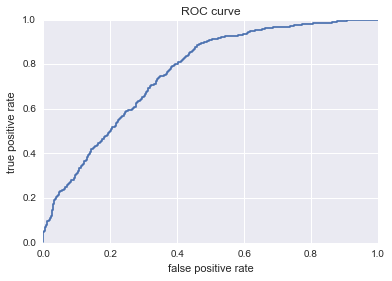

In [134]:
plt.title("ROC curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(fpr,tpr)

From the plot above, we can see that our model is better than randomly guessing given that the line is not straddling the center of the graph. However, we would like to see this line get closer to the top left corner of the graph which would indicate a better model. Below we will get the area under the curve (AUC).

In [156]:
roc_auc_score(train_target, train_decision)

0.76309613789163355

Our model has an AUC of 0.76. AUCs closer to 1 indicate a better fitting model.

# Test Model

Now that we have our model calibrated and finalized, we will test our best model on the test set.

In [145]:
final_model = train_fit

In [146]:
test_predict = final_model.predict(test_set)

In [153]:
pd.DataFrame(confusion_matrix(test_target, test_predict))

,0,1
0,130,87
1,48,163


In [154]:
print("precision: ",precision_score(test_target, test_predict))
print("   recall: ",   recall_score(test_target, test_predict))

precision:  0.652
   recall:  0.772511848341


# Conclusion